In [1]:
import numpy as np
import gvar as gv
import sys
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10, 8]

sys.path.append('../')
import fitter.data_loader as dl
import fitter.fit_manager as fm
import fitter.fitter as fit
import fitter.model_average as md

# Common functions -- can collapse

In [2]:
def make_table(self, param, observable='w0', cutoff=None):
    def prob_Mk_given_D(model_k, models):
        return 1 / np.sum([
            np.exp(self.fit_results[observable][model_l]['logGBF'] 
            - self.fit_results[observable][model_k]['logGBF']) for model_l in models])
    
    models = self.get_model_names(observable=observable)

    table = {}
    for mdl in models:
        if param in self.fit_results[observable][mdl]['posterior']:
            if cutoff is None or mdl.startswith(cutoff):
                table[mdl] = self.fit_results[observable][mdl]['posterior'][param]

    weights = {}
    for j, mdl in enumerate(table):
        weights[j] = gv.gvar(np.round(prob_Mk_given_D(mdl, list(table)), 3), 0)

    output = {}
    output.update(table)
    output.update(weights)

    return gv.tabulate(output, ncol=2)

In [3]:
def plot_model_breakdown(mdl_avg_dict):
    main_result_color = 'deepskyblue'
    colors = ['salmon', 'darkorange', 'mediumaquamarine', 'orchid',] 
    # For convenience
    def blank_line(label=None, **kwargs):
        nonlocal y
        nonlocal labels
        nonlocal y_color

        if label is None:
            pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
            plt.axhline(y-0.5, ls='--', color='slategrey', **kwargs)  
        elif label == '':
            y_color += 1
            y_color %= len(colors)
        else:
            y += 1
            y_color += 1
            y_color %= len(colors)
            labels.append(label)

    def amend_plot(value, label, color, starred=False):
        nonlocal y
        nonlocal labels

        x = gv.mean(value)
        xerr = gv.sdev(value)
        plt.errorbar(x=x, y=y, xerr=xerr, yerr=0.0,
                    alpha=0.8, color=color, elinewidth=5.0)
        if starred:
            plt.plot(x, y, color=main_result_color, marker='o',  mec='white', ms=12, zorder=3)
        labels.append(str(label))
        y += 1 

    # Make fig
    fig = plt.figure(figsize=(16, 14))
    for j, observable in enumerate(['w0', 't0']):
        param = 'A_s'

        if j == 0:
            axes = plt.axes([0.10,0.10,0.39,0.8])
        elif j == 1:
            axes = plt.axes([0.50,0.10,0.39,0.8])

        if param == 'w0':
            xlabel = r'$w_0$ (fm)'
        elif param == 'sqrt_t0':
            xlabel = r'$t_0^{1/2}$ (fm)'
        else:
            xlabel = param +' [%s]'%(observable)

        y = 0
        y_color = -3
        labels = []
            
        # Show band
        avg = mdl_avg_dict['quoted'].average(param, observable=observable)
        pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
        plt.axvspan(pm(avg, -1), pm(avg, +1), alpha=0.1, color=main_result_color)
        plt.axvline(pm(avg, 0), ls='-.', color=main_result_color)

        y_color = -3
        plt.axhline(y-0.5, lw=3)
        

        # ------
        # Separate
        blank_line(' ')

        #amend_plot(mdl_avg_dict['excld-ms'].average(param), 'exclude a12m220ms', colors[y_color])
        #amend_plot(mdl_avg_dict['excld-a06'].average(param), 'exclude a06m310L', colors[y_color])


        # ------
        # Separate
        blank_line('')

        # exclude alpha_s
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['eps2a_defn'] == 'variable']
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable, models=models), r'variable $\epsilon^2_a$', colors[y_color])

        # include alpha_s
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['eps2a_defn'] == 'w0_original']
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable, models=models), r'fixed $\epsilon^2_a$', colors[y_color])



        # ------
        # Separate
        blank_line('')

        # exclude alpha_s
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['include_alphas'] == False]
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable, models=models), r'exclude $\alpha_S$', colors[y_color])

        # include alpha_s
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['include_alphas'] == True]
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable, models=models), r'include $\alpha_S$', colors[y_color])
        

        # ------
        # Separate
        #blank_line()


        # ------
        # Separate
        blank_line('')

        # chiral cutoff: mO 
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['chiral_cutoff'] == 'mO']
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable, models=models), r'$\Lambda_\chi = m_\Omega$', colors[y_color])

        # chiral cutoff: Fpi
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['chiral_cutoff'] == 'Fpi']
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable, models=models), r'$\Lambda_\chi = 4 \pi F_\pi$', colors[y_color])


        # ----
        # Separate
        blank_line('')

        # n2lo-full fits
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['order'] == 'n2lo']
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable, models=models), r'N$^2$LO', colors[y_color])

        # n3lo-full fits
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['order'] == 'n3lo']
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable,  models=models), r'N$^3$LO', colors[y_color])


        # ----
        # Separate
        blank_line('')

        # ct only
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['include_log'] == False]
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable, models=models), r'$\chi$pt-ct', colors[y_color])

        # xpt only
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['include_log'] == True]
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable, models=models), r'$\chi$pt-full', colors[y_color])

        # Separate
        blank_line(' ')
        amend_plot(mdl_avg_dict['quoted'].average(param, observable=observable), r'model average', main_result_color, True)

        # Format axes
        plt.xticks(fontsize=22)
        #plt.locator_params(axis='x', nbins=9)
        #for n, l in enumerate(axes.xaxis.get_ticklabels()):
        #    if n % 2 != 0:
        #        l.set_visible(False)
        
        if j == 0:
            plt.tick_params(axis='y', left=False, labelsize=26)
            plt.yticks(range(len(labels)), labels)
        else:
            plt.yticks([])
        plt.ylim(-0.5, y)

        plt.xlabel(xlabel, fontsize=30)

    plt.tight_layout()
    fig = plt.gcf()
    plt.close()

    return fig

# Tests on improved gradient flow scales, original priors

In [4]:
model_average = md.model_average('2024_03_27-strangeness_tests')
print(model_average)


{'name': '2024_03_27-strangeness_tests', 'models': ['Fpi_n2lo_variable', 'Fpi_n2lo_alphas_variable', 'Fpi_n2lo_alphas_fv_variable', 'Fpi_n2lo_fv_variable', 'Fpi_n2lo_log_variable', 'Fpi_n2lo_log_alphas_variable', 'Fpi_n2lo_log_alphas_fv_variable', 'Fpi_n2lo_log_fv_variable', 'Fpi_n3lo_variable', 'Fpi_n3lo_alphas_variable', 'Fpi_n3lo_alphas_fv_variable', 'Fpi_n3lo_fv_variable', 'Fpi_n3lo_log_log2_variable', 'Fpi_n3lo_log_log2_alphas_variable', 'Fpi_n3lo_log_log2_alphas_fv_variable', 'Fpi_n3lo_log_log2_fv_variable', 'Om_n2lo_variable', 'Om_n2lo_alphas_variable', 'Om_n2lo_alphas_fv_variable', 'Om_n2lo_fv_variable', 'Om_n2lo_log_variable', 'Om_n2lo_log_alphas_variable', 'Om_n2lo_log_alphas_fv_variable', 'Om_n2lo_log_fv_variable', 'Om_n3lo_variable', 'Om_n3lo_alphas_variable', 'Om_n3lo_alphas_fv_variable', 'Om_n3lo_fv_variable', 'Om_n3lo_log_log2_variable', 'Om_n3lo_log_log2_alphas_variable', 'Om_n3lo_log_log2_alphas_fv_variable', 'Om_n3lo_log_log2_fv_variable', 'Fpi_n2lo_w0orig', 'Fpi_n2lo

## Model average for c_s

In [5]:
print('Model average for c_s')
print('c_s [w0]:', model_average.average('A_s', observable='w0'))
print('c_s [t0]:', model_average.average('A_s', observable='t0'))

Model average for c_s
c_s [w0]: 1.19(36)
c_s [t0]: 1.25(33)


In [6]:
print("Individual models\n")
print('from fitting w0 mO [c_s & corresponding weight]:')
print(make_table(model_average, param='A_s', observable='w0', cutoff='Fpi'))
print()
print(make_table(model_average, param='A_s', observable='w0', cutoff='Om'))

print('\nfrom fitting sqrt(t0) mO [c_s & corresponding weight]:')
print(make_table(model_average, param='A_s', observable='t0', cutoff='Fpi'))
print()
print(make_table(model_average, param='A_s', observable='t0', cutoff='Om'))


Individual models

from fitting w0 mO [c_s & corresponding weight]:
                             key/index        value                               key/index        value
---------------------------------------------------  ---------------------------------------------------
           Fpi_n2lo_alphas_fv_variable    1.18 (34)                                       0    0.091 (0)
             Fpi_n2lo_alphas_fv_w0orig    1.15 (34)                                       1    0.006 (0)
              Fpi_n2lo_alphas_variable    1.18 (34)                                       2    0.091 (0)
                Fpi_n2lo_alphas_w0orig    1.15 (34)                                       3    0.006 (0)
                  Fpi_n2lo_fv_variable    1.23 (34)                                       4    0.004 (0)
                    Fpi_n2lo_fv_w0orig    1.23 (34)                                       5        0 ± 0
       Fpi_n2lo_log_alphas_fv_variable    1.13 (35)                                       6 

{'name': '2024_03_27-strangeness_tests', 'models': ['Fpi_n2lo_variable', 'Fpi_n2lo_alphas_variable', 'Fpi_n2lo_alphas_fv_variable', 'Fpi_n2lo_fv_variable', 'Fpi_n2lo_log_variable', 'Fpi_n2lo_log_alphas_variable', 'Fpi_n2lo_log_alphas_fv_variable', 'Fpi_n2lo_log_fv_variable', 'Fpi_n3lo_variable', 'Fpi_n3lo_alphas_variable', 'Fpi_n3lo_alphas_fv_variable', 'Fpi_n3lo_fv_variable', 'Fpi_n3lo_log_log2_variable', 'Fpi_n3lo_log_log2_alphas_variable', 'Fpi_n3lo_log_log2_alphas_fv_variable', 'Fpi_n3lo_log_log2_fv_variable', 'Om_n2lo_variable', 'Om_n2lo_alphas_variable', 'Om_n2lo_alphas_fv_variable', 'Om_n2lo_fv_variable', 'Om_n2lo_log_variable', 'Om_n2lo_log_alphas_variable', 'Om_n2lo_log_alphas_fv_variable', 'Om_n2lo_log_fv_variable', 'Om_n3lo_variable', 'Om_n3lo_alphas_variable', 'Om_n3lo_alphas_fv_variable', 'Om_n3lo_fv_variable', 'Om_n3lo_log_log2_variable', 'Om_n3lo_log_log2_alphas_variable', 'Om_n3lo_log_log2_alphas_fv_variable', 'Om_n3lo_log_log2_fv_variable', 'Fpi_n2lo_w0orig', 'Fpi_n2lo

/tmp/ipykernel_81523/3666224694.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


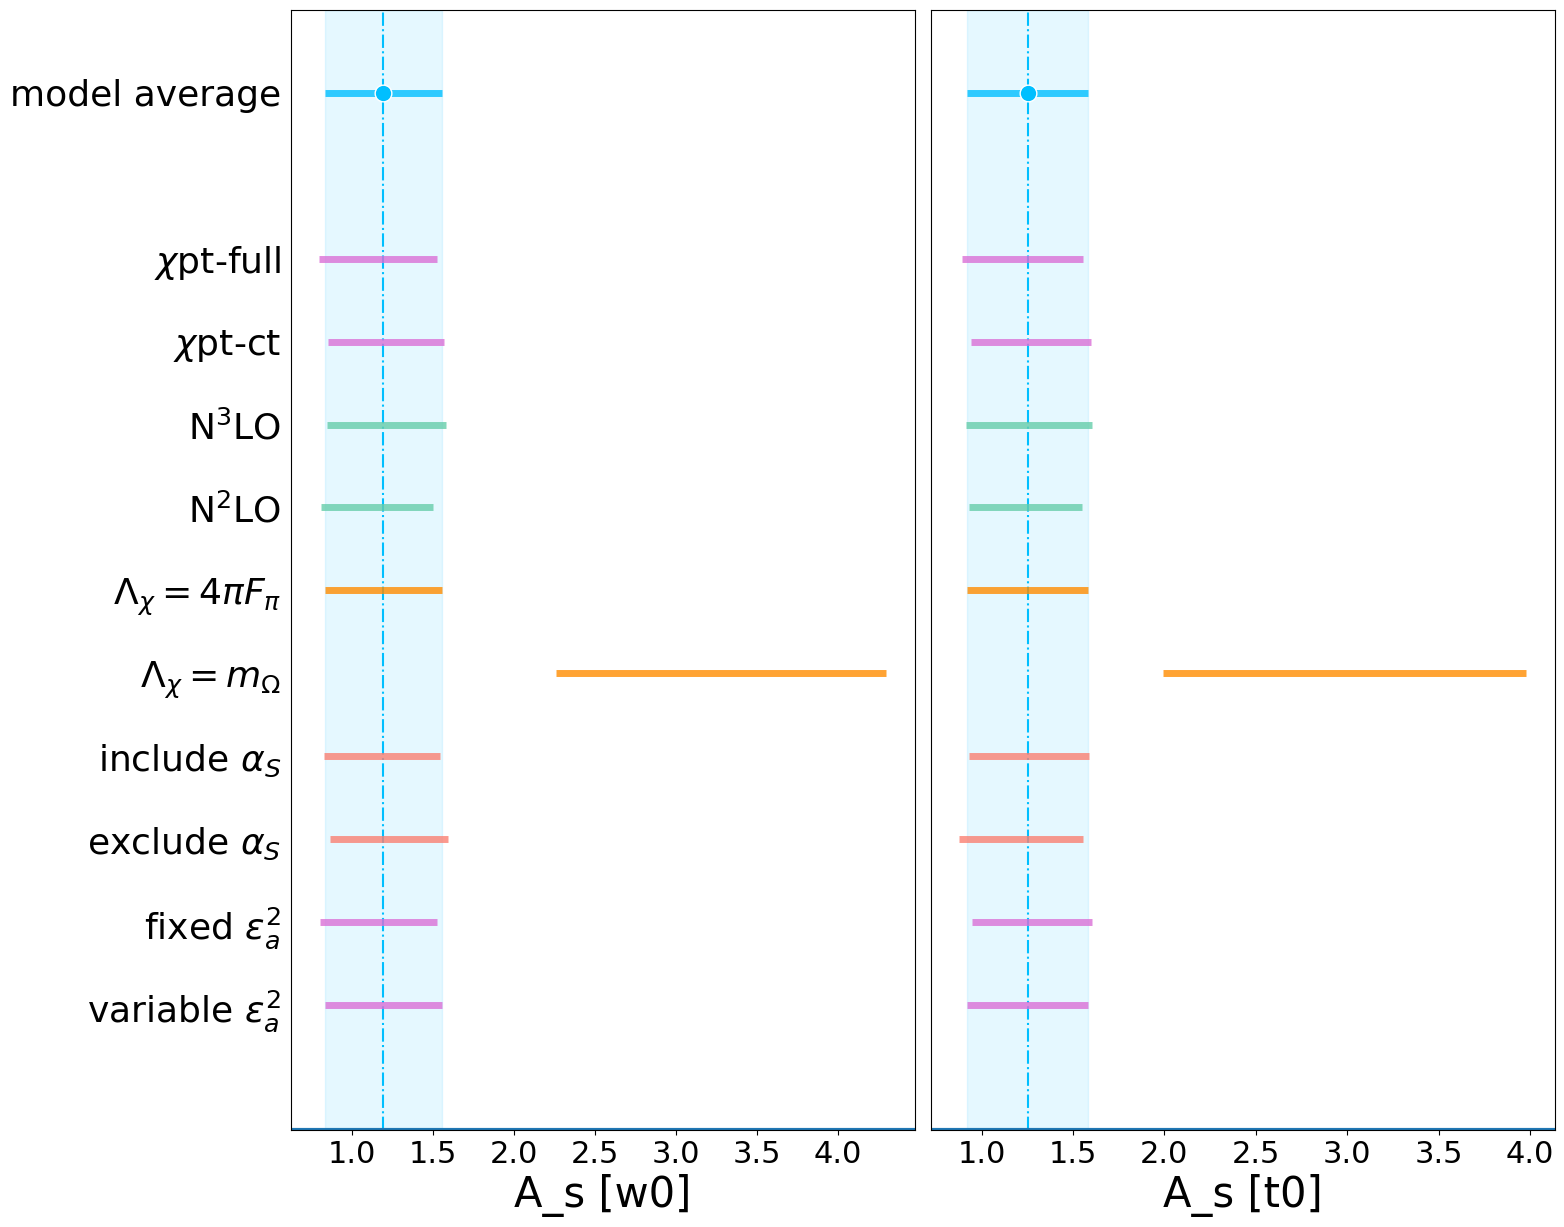

In [7]:
collections = {
    'quoted' : '2024_03_27-strangeness_tests'
}
mdl_avg_dict = {clctn : md.model_average(collections[clctn]) for clctn in collections}

plot_model_breakdown(mdl_avg_dict)
    

## Model average for d_as

In [8]:
print('Model average for d_as')
print('d_as [w0]:', model_average.average('A_as', observable='w0'))
print('d_as [t0]:', model_average.average('A_as', observable='t0'))

Model average for d_as
d_as [w0]: 0.87(86)
d_as [t0]: 0.95(74)


In [9]:
print("Individual models\n")
print('from fitting w0 mO [d_as & corresponding weight]:')
print(make_table(model_average, param='A_as', observable='w0', cutoff='Fpi'))
print(make_table(model_average, param='A_as', observable='w0', cutoff='Om'))
print('\nfrom fitting sqrt(t0) mO [d_as & corresponding weight]:')
print(make_table(model_average, param='A_as', observable='t0', cutoff='Fpi'))
print(make_table(model_average, param='A_as', observable='t0', cutoff='Om'))

Individual models

from fitting w0 mO [d_as & corresponding weight]:
                             key/index        value                               key/index        value
---------------------------------------------------  ---------------------------------------------------
           Fpi_n2lo_alphas_fv_variable    0.97 (83)                                       0    0.091 (0)
             Fpi_n2lo_alphas_fv_w0orig    0.84 (94)                                       1    0.006 (0)
              Fpi_n2lo_alphas_variable    0.97 (83)                                       2    0.091 (0)
                Fpi_n2lo_alphas_w0orig    0.84 (94)                                       3    0.006 (0)
                  Fpi_n2lo_fv_variable    1.03 (78)                                       4    0.004 (0)
                    Fpi_n2lo_fv_w0orig    0.90 (89)                                       5        0 ± 0
       Fpi_n2lo_log_alphas_fv_variable    0.94 (83)                                       6

# Tests on improved gradient flow scales, wide priors

In [10]:
model_average = md.model_average('2024_03_27-strangeness_tests_wide_priors')
print(model_average)


{'name': '2024_03_27-strangeness_tests_wide_priors', 'models': ['Fpi_n2lo_variable', 'Fpi_n2lo_alphas_variable', 'Fpi_n2lo_alphas_fv_variable', 'Fpi_n2lo_fv_variable', 'Fpi_n2lo_log_variable', 'Fpi_n2lo_log_alphas_variable', 'Fpi_n2lo_log_alphas_fv_variable', 'Fpi_n2lo_log_fv_variable', 'Fpi_n3lo_variable', 'Fpi_n3lo_alphas_variable', 'Fpi_n3lo_alphas_fv_variable', 'Fpi_n3lo_fv_variable', 'Fpi_n3lo_log_log2_variable', 'Fpi_n3lo_log_log2_alphas_variable', 'Fpi_n3lo_log_log2_alphas_fv_variable', 'Fpi_n3lo_log_log2_fv_variable', 'Om_n2lo_variable', 'Om_n2lo_alphas_variable', 'Om_n2lo_alphas_fv_variable', 'Om_n2lo_fv_variable', 'Om_n2lo_log_variable', 'Om_n2lo_log_alphas_variable', 'Om_n2lo_log_alphas_fv_variable', 'Om_n2lo_log_fv_variable', 'Om_n3lo_variable', 'Om_n3lo_alphas_variable', 'Om_n3lo_alphas_fv_variable', 'Om_n3lo_fv_variable', 'Om_n3lo_log_log2_variable', 'Om_n3lo_log_log2_alphas_variable', 'Om_n3lo_log_log2_alphas_fv_variable', 'Om_n3lo_log_log2_fv_variable', 'Fpi_n2lo_w0orig

## Model average for c_s

In [11]:
print('Model average for c_s')
print('c_s [w0]:', model_average.average('A_s', observable='w0'))
print('c_s [t0]:', model_average.average('A_s', observable='t0'))

Model average for c_s
c_s [w0]: 1.9(1.0)
c_s [t0]: 2.27(96)


In [12]:
print("Individual models\n")
print('from fitting w0 mO [c_s & corresponding weight]:')
print(make_table(model_average, param='A_s', observable='w0', cutoff='Fpi'))
print()
print(make_table(model_average, param='A_s', observable='w0', cutoff='Om'))

print('\nfrom fitting sqrt(t0) mO [c_s & corresponding weight]:')
print(make_table(model_average, param='A_s', observable='t0', cutoff='Fpi'))
print()
print(make_table(model_average, param='A_s', observable='t0', cutoff='Om'))


Individual models

from fitting w0 mO [c_s & corresponding weight]:
                             key/index        value                               key/index        value
---------------------------------------------------  ---------------------------------------------------
           Fpi_n2lo_alphas_fv_variable    2.01 (88)                                       0    0.221 (0)
             Fpi_n2lo_alphas_fv_w0orig    1.95 (89)                                       1    0.023 (0)
              Fpi_n2lo_alphas_variable    2.01 (88)                                       2    0.221 (0)
                Fpi_n2lo_alphas_w0orig    1.95 (89)                                       3    0.023 (0)
                  Fpi_n2lo_fv_variable    1.72 (89)                                       4    0.026 (0)
                    Fpi_n2lo_fv_w0orig    1.73 (90)                                       5    0.003 (0)
       Fpi_n2lo_log_alphas_fv_variable    2.07 (91)                                       6 

{'name': '2024_03_27-strangeness_tests_wide_priors', 'models': ['Fpi_n2lo_variable', 'Fpi_n2lo_alphas_variable', 'Fpi_n2lo_alphas_fv_variable', 'Fpi_n2lo_fv_variable', 'Fpi_n2lo_log_variable', 'Fpi_n2lo_log_alphas_variable', 'Fpi_n2lo_log_alphas_fv_variable', 'Fpi_n2lo_log_fv_variable', 'Fpi_n3lo_variable', 'Fpi_n3lo_alphas_variable', 'Fpi_n3lo_alphas_fv_variable', 'Fpi_n3lo_fv_variable', 'Fpi_n3lo_log_log2_variable', 'Fpi_n3lo_log_log2_alphas_variable', 'Fpi_n3lo_log_log2_alphas_fv_variable', 'Fpi_n3lo_log_log2_fv_variable', 'Om_n2lo_variable', 'Om_n2lo_alphas_variable', 'Om_n2lo_alphas_fv_variable', 'Om_n2lo_fv_variable', 'Om_n2lo_log_variable', 'Om_n2lo_log_alphas_variable', 'Om_n2lo_log_alphas_fv_variable', 'Om_n2lo_log_fv_variable', 'Om_n3lo_variable', 'Om_n3lo_alphas_variable', 'Om_n3lo_alphas_fv_variable', 'Om_n3lo_fv_variable', 'Om_n3lo_log_log2_variable', 'Om_n3lo_log_log2_alphas_variable', 'Om_n3lo_log_log2_alphas_fv_variable', 'Om_n3lo_log_log2_fv_variable', 'Fpi_n2lo_w0orig

/tmp/ipykernel_81523/3666224694.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


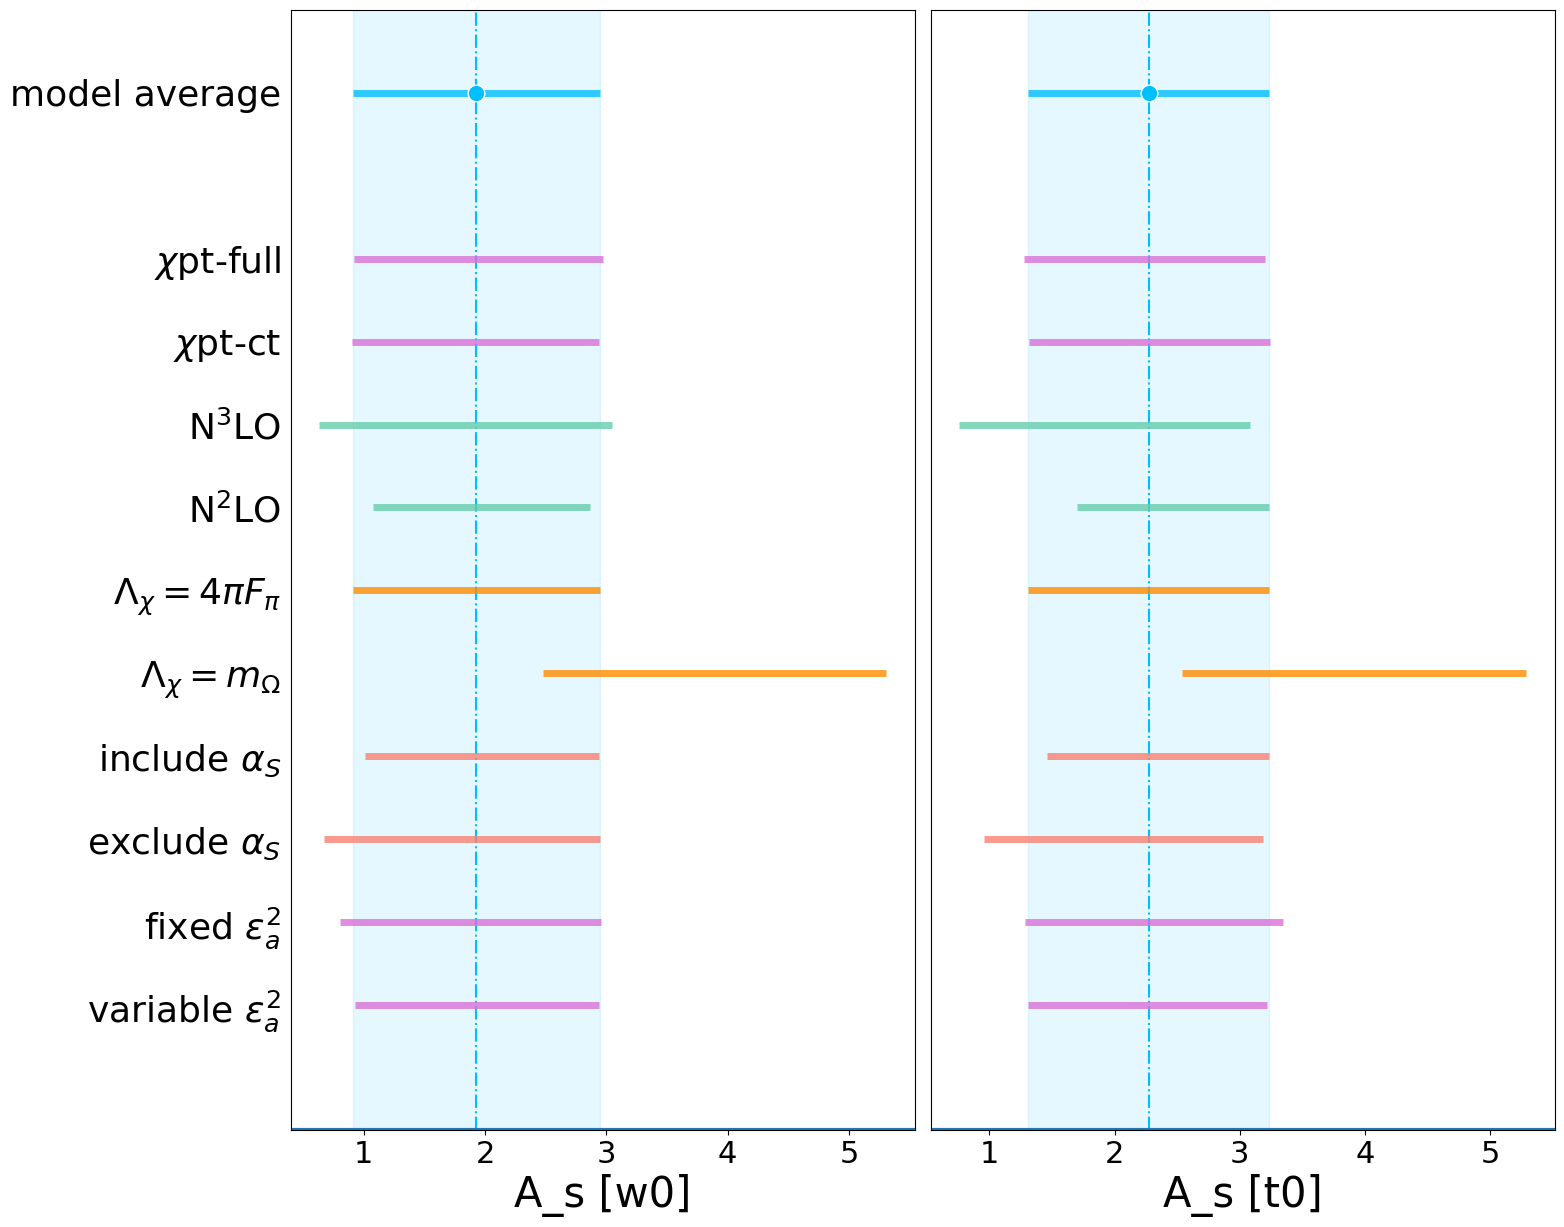

In [13]:
collections = {
    'quoted' : '2024_03_27-strangeness_tests_wide_priors'
}
mdl_avg_dict = {clctn : md.model_average(collections[clctn]) for clctn in collections}

plot_model_breakdown(mdl_avg_dict)
    

## Model average for d_as

In [14]:
print('Model average for c_s')
print('d_as [w0]:', model_average.average('A_as', observable='w0'))
print('d_as [t0]:', model_average.average('A_as', observable='t0'))

Model average for c_s
d_as [w0]: 0.9(2.8)
d_as [t0]: 2.1(2.4)


In [15]:
print("Individual models\n")
print('from fitting w0 mO [d_as & corresponding weight]:')
print(make_table(model_average, param='A_as', observable='w0', cutoff='Fpi'))
print(make_table(model_average, param='A_as', observable='w0', cutoff='Om'))
print('\nfrom fitting sqrt(t0) mO [d_as & corresponding weight]:')
print(make_table(model_average, param='A_as', observable='t0', cutoff='Fpi'))
print(make_table(model_average, param='A_as', observable='t0', cutoff='Om'))

Individual models

from fitting w0 mO [d_as & corresponding weight]:
                             key/index          value                               key/index          value
-----------------------------------------------------  -----------------------------------------------------
           Fpi_n2lo_alphas_fv_variable      1.0 (2.5)                                       0      0.221 (0)
             Fpi_n2lo_alphas_fv_w0orig    0.10 (2.48)                                       1      0.023 (0)
              Fpi_n2lo_alphas_variable      1.0 (2.5)                                       2      0.221 (0)
                Fpi_n2lo_alphas_w0orig    0.10 (2.48)                                       3      0.023 (0)
                  Fpi_n2lo_fv_variable      0.5 (2.5)                                       4      0.026 (0)
                    Fpi_n2lo_fv_w0orig     -0.9 (2.5)                                       5      0.003 (0)
       Fpi_n2lo_log_alphas_fv_variable      1.1 (2.5)      